In [2]:
# basic python libraries
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score , classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier , plot_tree
# keras imports
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD , Adagrad , Adadelta , Adam
from keras import layers
from keras import activations
from keras import losses
from keras.callbacks import EarlyStopping , LearningRateScheduler , ReduceLROnPlateau
import tensorflow as tf

import seaborn as sns


In [3]:
# Spliting the dataframe into two parts: X and y. X is the original dataframe, and y is a new dataframe with just the target_column
def split_data_target( dataframe , target_column : str ):

    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]
    
    return X , y

# Converting a list of strings to an integer
def convert_from_str_to_int(string_list : list , conversion_dict : dict):

    """
        This function takes a convertion dictionary : { "Famale" : 1 , "Male" : 0}
        and for every element in the string_list, converts it according to this dictionaty
    """

    new_list = []
    for item in string_list:
        new_list.append(conversion_dict[item])
    
    return new_list

# Converting the dataframe to a NumPy array
def df_to_list(df):
    df_keys = list(df.keys())

    list_of_lists = []

    for i in range(len(df)):
        cur_list = []
        for k in df_keys:
            cur_list.append(df[k][i])
        
        list_of_lists.append(cur_list)
    
    return list_of_lists

# Creating a neural network with the given input and output node numbers and activation function 
def genarate_model( 
    n_list : list , 
    activations_list : list ,
    input_dim : int , 
    input_activation_function : str = "relu" ,
    output_node_number : int = 1,
    output_activation_function : str = "sigmoid",
    model_visualization : bool = False, 
    model_summary : bool = False, 
    first_hidden_layer : int = 32,
    use_dropout : bool = True,
    dropout_rate : float = 0.5,
    ):

# Defining the model architecture
    model = Sequential()
    
    # Adding Dense layers to the model, one after another, with input_dim and activation as arguments
    model.add(Dense(first_hidden_layer , input_dim=input_dim, activation=input_activation_function)) 

    for node , act_function in zip(n_list , activations_list):
        model.add(Dense(node, activation=act_function))

    # Checking if use_dropout should be used or not   
    if use_dropout:
      model.add(Dropout(dropout_rate))  
  
    model.add(Dense(output_node_number, activation=output_activation_function))

    # Printing the model summery and graphs
    if model_summary:
        print(model.summary())
    if model_visualization:
        plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
        plt.show('model_plot.png')

    return model


def scheduler_1(epoch , lr):
  """
    This function reduce the learning rate in every 6th
    epoch by 30%
  """
  if (epoch+1)%6 == 0:
    lr *= 0.7

  return lr 

def scheduler_2(epoch, lr):

  """
    This funcitons reduce the learning rate in
    every epoch after the 10th epoch by exp of -0.1
  """
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

def get_callback_functions(monitor : str = "val_accuracy" , epoch_number : int = None , callback_functions : list = []):
          # callback function
          callback_option = {
              "es" : EarlyStopping(monitor=monitor, mode='max', patience=15,  restore_best_weights=True),
              "rbw" : EarlyStopping(monitor=monitor, mode='max', patience=epoch_number,  restore_best_weights=True),
              "lrs_1" : LearningRateScheduler(scheduler_1),
              "lrs_2" : LearningRateScheduler(scheduler_2),
              "rlrp" : ReduceLROnPlateau(factor=0.2,patience=5, min_lr=0.000001),
          }

          callback_list = []
          for cf in callback_functions:
              if cf == "lrs":
                callback_list.append(callback_option["lrs_1"])
              else:  
                callback_list.append(callback_option[cf])

          return callback_list


def find_best_model_fit(model ,  epoch_number : int , num_of_iters : int = 1 , callback_functions : list = ["es" , "lrs_1" , "rbw"]):
    
    best_model = None # Model that has been found to have the highest accuracy score
    best_acc = 0
    best_history = None # Contains information about how many iterations it took to find the best model and what its accuracy was at each iteration
    
    acc_list = []
    

    for _ in range(num_of_iters):
            
        
        # Training the model (using the validation set)
        history = model.fit(
            X_train_norm ,
             y_train , 
             validation_data=(X_validation_norm , y_validation), 
             epochs = epoch_number , 
             verbose=0,
             callbacks=get_callback_functions(callback_functions=callback_functions , epoch_number=epoch_number),
             )
        
        
        # Making a prediction (using the test set)
        y_pred_prob_nn_1 = model.predict(X_test_norm)
        y_pred_class_nn_1 = np.rint(y_pred_prob_nn_1)
        
        # Printing the roc auc score for each iteration
        cur_acc = accuracy_score(y_test,y_pred_class_nn_1)
        res = roc_auc_score(y_test , y_pred_class_nn_1)
      
        acc_list.append(cur_acc)
        
        # Checking if the current accuracy score has surpassed the best accuracy score, if not we save the current accuracy
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_model = model
            best_history = history

    # Printing the accuracy of the best model that has been trained
    return best_model , best_history




## Importing the datasets

We have uploaded the `csv` files to a GitHub repo. Now all we need is to call the url to that file in this repo.

In [4]:
train_data = pd.read_csv()
test_data = pd.read_csv()
validation_data = pd.read_csv()

## Split the data

The datasets need to be split and orderd.

In [5]:

# Spliting the data to X and y
X_train , y_train = split_data_target(train_data , "Diagnosis")
X_test , y_test = split_data_target(test_data , "Diagnosis")
X_validation , y_validation = split_data_target(validation_data , "Diagnosis")

# Convert the string columns into integer columns 
X_train["gender"] = convert_from_str_to_int(X_train["gender"] , {"Female" : 1 , "Male" : 0})
y_train = convert_from_str_to_int(y_train , {"NonCancer" : 0 , "Cancer" : 1})
X_test["gender"] = convert_from_str_to_int(X_test["gender"] , {"Female" : 1 , "Male" : 0})
y_test = convert_from_str_to_int(y_test , {"NonCancer" : 0 , "Cancer" : 1})
X_validation["gender"] = convert_from_str_to_int(X_validation["gender"] , {"Female" : 1 , "Male" : 0})
X_validation = X_validation.drop(columns=["PtNo"])
y_validation = convert_from_str_to_int(y_validation , {"NonCancer" : 0 , "Cancer" : 1})


## Implement the feature selection algo

In this section we are using the `RandomForestClassifier` class to choose from 123 features of this dataset the best features.

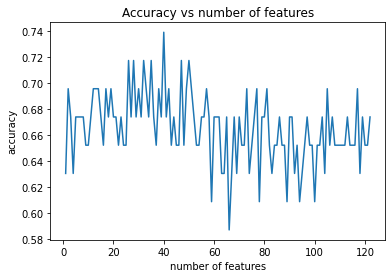


Using 40 features out of 123

1. NM_001011552
2. NM_024296
3. NM_000490
4. NM_022059
5. NM_003978
6. NM_032567
7. NM_001114726
8. NM_001860
9. NM_020715
10. NM_025099
11. NM_138281
12. NM_148896
13. NM_001882
14. NM_032943
15. NM_001143820
16. NM_015497
17. NM_014280
18. NM_001280539
19. NM_020746
20. NM_005795
21. NM_032753
22. NM_024751
23. NM_015549
24. NM_001001794
25. NM_000681
26. NM_003592
27. NM_018316
28. NM_003946
29. Epi
30. NM_001136498
31. NM_001039771
32. NM_032219
33. NM_007210
34. NM_030973
35. NM_001287444
36. NM_001308147
37. age
38. NM_001204269
39. NM_198552
40. NM_001099221


In [6]:

# Implament feature selection using random forest
fs_n = [] # Used to store the feature importance scores for each individual key in X_train
fs_acc = [] # Hold all of the feature importance scores accuracy for all of the keys in X_train
best_acc = 0
best_n = 0
original_len = len(X_train.keys())
best_top_features = []
estimators = 150 # The number of desicion trees

clf = RandomForestClassifier(n_estimators=estimators)
clf.fit(X_train, y_train)
importances = clf.feature_importances_

# Searching all the possible numbers for the best accuracy
for n in range(1 , len(X_train.keys())):
  # saving a list of n
  fs_n.append(n)
  # getting the n top features to this list
  top_n_features = importances.argsort()[-n:]

  X_train_top = {}
  X_test_top = {}
  X_validation_top = {}

  # generate new dataframes with only the n top features
  for feature in top_n_features:
    f_name = list(X_train.keys())[feature]
    X_train_top[f_name] = X_train[f_name]
    X_test_top[f_name] = X_test[f_name]
    X_validation_top[f_name] = X_validation[f_name]

  X_train_top = pd.DataFrame.from_dict(X_train_top)
  X_test_top = pd.DataFrame.from_dict(X_test_top)
  X_validation_top = pd.DataFrame.from_dict(X_validation_top)
  
  #  Training the random forest classifier on the selected feature
  clf2 = RandomForestClassifier(n_estimators=estimators)
  clf2.fit(X_train_top, y_train)
  
  y_pred = clf2.predict(X_test_top)
  acc = accuracy_score(y_pred , y_test)
  # creating a list of all accuracies
  fs_acc.append(acc)

  if acc > best_acc:
    best_acc = acc
    best_n = n
    best_top_features = top_n_features 

  del clf2


# Ploting the accuracy as a function of the number of features 
plt.plot(fs_n , fs_acc)
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.title('Accuracy vs number of features')
plt.show()

print(f"\nUsing {best_n} features out of {original_len}\n")


# Changing the data to match the best feature selection
for index , feature in enumerate(best_top_features):
  f_name = list(X_train.keys())[feature]
  print(f"{index+1}. {f_name}")
  X_train_top[f_name] = X_train[f_name]
  X_test_top[f_name] = X_test[f_name]
  X_validation_top[f_name] = X_validation[f_name]

X_train = pd.DataFrame.from_dict(X_train_top)
X_test = pd.DataFrame.from_dict(X_test_top)
X_validation = pd.DataFrame.from_dict(X_validation_top)

## Normalize the data

Normalizing data is a technique used to preprocess data before feeding it into a machine learning model. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information. It is often used to ensure that all features of the data are on a similar scale, which can make training machine learning models more efficient and improve their performance.

In [7]:

# Converting the dataframes into list of all the rows in the dataframe and normelizing the data
normalizer = StandardScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_validation_norm = normalizer.transform(X_validation)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_validation = np.asarray(y_validation)


## Building the neural network


In [24]:
# hiper parameters
input_dim = len(list(X_train.keys()))
best_config = {}
best_acc = 0
activations_list = ["relu" , "relu" , "relu" , "relu"] # activation function in each hidden layer
loss_function = 'binary_crossentropy'
dor = 0.9
option = 1


for epoch_number in [500]:
  for learning_rate in [0.0001]:
    for beta1 in [0.99]:
      for n_list in [[100 , 120]]:
        for use_do in [False]:
          for opt in [SGD(learning_rate = learning_rate , momentum=0.9)]:
            for cf in [["es"]]:
              

              model = genarate_model(
                  n_list=n_list,
                  activations_list=activations_list,
                  input_dim=input_dim,
                  model_summary = False,
                  model_visualization=True,
                  use_dropout=use_do,
                  dropout_rate = dor,
              )

              # Compile the model
              model.compile(opt, loss=loss_function, metrics=['accuracy'])


              # find the best model
              model , history = find_best_model_fit(model , epoch_number= epoch_number , callback_functions=cf)
              option += 1

              
              if history.history["val_accuracy"][-1] > best_acc:
                best_acc = history.history["val_accuracy"][-1] 
                best_config = {
                    "epoch_number" : epoch_number,
                    "learning_rate" :learning_rate,
                    "n_list" : n_list,
                    "use_do" : use_do,
                    "optimizer" : opt,
                    "dropout_rate" : dor,
                    "loss" : loss_function,
                    "model" : model,
                    "model_val_acc" : history.history["val_accuracy"][-1],
                    "history" : history,
                    "callback_functions" : cf,
                }
                print(best_config)

            
            
          

print(f"Out of {option} models this is the best configuration found")
for key in best_config.keys():
  print(key , " : " , best_config[key])




2/2 [==============================] - 0s 9ms/step
{'epoch_number': 500, 'learning_rate': 0.0001, 'n_list': [100, 120], 'use_do': False, 'optimizer': <keras.optimizers.optimizer_v2.gradient_descent.SGD object at 0x7f828cfb4760>, 'dropout_rate': 0.9, 'loss': 'binary_crossentropy', 'model': <keras.engine.sequential.Sequential object at 0x7f828cfb4df0>, 'model_val_acc': 0.6730769276618958, 'history': <keras.callbacks.History object at 0x7f82f365ddc0>, 'callback_functions': ['es']}
Out of 2 models this is the best configuration found
epoch_number  :  500
learning_rate  :  0.0001
n_list  :  [100, 120]
use_do  :  False
optimizer  :  <keras.optimizers.optimizer_v2.gradient_descent.SGD object at 0x7f828cfb4760>
dropout_rate  :  0.9
loss  :  binary_crossentropy
model  :  <keras.engine.sequential.Sequential object at 0x7f828cfb4df0>
model_val_acc  :  0.6730769276618958
history  :  <keras.callbacks.History object at 0x7f82f365ddc0>
callback_functions  :  ['es']


## Printing the model metrics
1. model accuracy and validation accuracy over the number of epochs
2. model loss and validation loss over the number of epochs
3. confusion matrix for this model

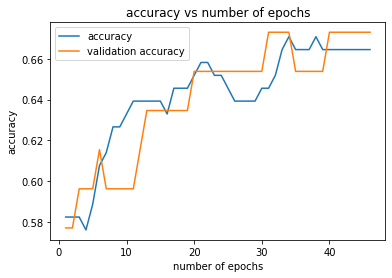

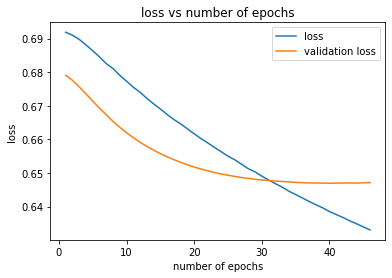

2/2 [==============================] - 0s 8ms/step


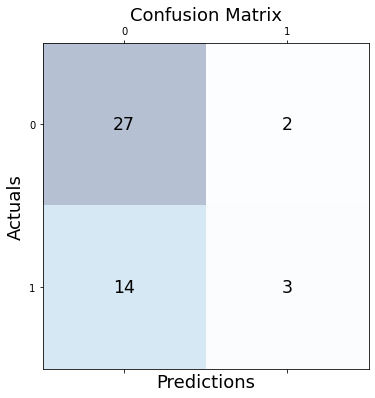

In [25]:
history = best_config["history"]

# Ploting the accuracy and loss function with the train and test of  best model 
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

en = [i+1 for i in range(len(acc))]

plt.plot(en , acc , label="accuracy")
plt.plot(en , val_acc , label="validation accuracy")
plt.title("accuracy vs number of epochs")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(en , loss , label="loss")
plt.plot(en , val_loss , label="validation loss")
plt.title("loss vs number of epochs")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


## Creating the confusion matrix
# Get the predictions
y_pred = model.predict(X_test_norm)
# Calculate the confusion matrix

def binary(num : float) -> int:
  if num >= 0.5:
    return 1
  return 0
y_pred = [binary(i[0]) for i in y_pred]


conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()



## Use KNN model for compare

We can use the KNN model from HW2 to compare with our neural network model.

In [26]:
import math
import pandas as pd
from pandas import read_csv
import numpy as np
import operator

# Importing the hamming and euclidean distance functions
from scipy.spatial.distance import hamming , euclidean

# also found a function for calculating manhattan distance
def manhattan(p, q):
    """ 
    Return the manhattan distance between points p and q
    assuming both to have the same number of dimensions
    """
    # Sum of absolute difference between coordinates
    distance = 0
    for p_i,q_i in zip(p,q):
        distance += abs(p_i - q_i)
    return distance

# Creating a basic class for saving the distance for every point
# In the data while saving the related tag (target) value 
class myDist():
  def __init__(self , dist  : int , tag : str):
    self.dist = dist
    self.tag = tag


def my_classify( data , target , point , k = 1  , dist_calc_method = "e"):
  """
  This function classify an unknown point based on three methods of calculation:
  1. euclidean
  2. manhattan
  3. hamming

  The function takes a data metrix, target vector, point vector with the same
  length the lists in the data and try to predict the tag for the given point
  """
  
  results = {}
  cls_list = []
  method = dist_calc_method

  if method == "e":
    the_method = "euclidean"
  if method == "m":
    the_method = "manhattan"
  if method == "h":
    the_method = "hamming"

  # Calculating the distances
  for d , t in zip(data,target):
    if method == "e":
      dist = euclidean(d , point)
    elif method == "m":
      dist = manhattan(d , point)
    elif method == "h":
      dist = hamming(d , point)
    else:
      dist = euclidean(d , point)
    
    cls_list.append(myDist(dist , t))
    results[t] = 0
  
  # Sorting the list
  cls_list.sort(key=operator.attrgetter('dist'))

  # Calculate the number of each target for classifing the unknown point's target
  for i in range(k):
    cur_my_dist = cls_list[i]
    try:
      # Print(f"{i+1}. {cls_list[i].dist} , {cls_list[i].tag}")
      results[cur_my_dist.tag] += 1
    except:
      pass

  m = max(results.values())
  index = list(results.values()).index(m)
  prediction = list(results.keys())[index]

  return prediction , the_method

def knn_model(train_data , train_tags , test_data , test_tags , knn = 3 ,clac_method = "e"):
  """
  This function use a train and test datasets, and for a given k and calculation method [e,m,h]
  finding a predicted tag for each point in the test data set. It counts the number of correct
  predictions and returns the accuracy of the model and the distance calculation method used
  """

  correct = 0
  tries = 0
  y_pred = []

  for point , tag in zip(test_data , test_tags):
    # Using the function from the warmup section
    prd , used = my_classify(train_data , train_tags , point , k=knn , dist_calc_method=clac_method)
    y_pred.append(prd)
    # Calculate the accuracy - checking for a correct prediction
    if prd == tag:
      correct += 1
    tries +=1
  
  acc = accuracy_score(test_tags, y_pred)
  report = classification_report(test_tags, y_pred)
  
  return report , used , acc

# Checking for every calculation method with three k
methods = ["e" ,"m" ,"h"]
knns = [1,7,15]

config = {
    "best_k" : None,
    "best_knn_acc" : 0,
    'best_report' : None,
    "best_used_method" : None,
}


for mt in methods:
  for knn in knns:
    report , used_method , cur_acc = knn_model(X_train_norm , y_train , X_test_norm , y_test , knn=knn , clac_method =mt)
    if cur_acc > config["best_knn_acc"]:
      config = {
          "best_k" : knn,
          "best_knn_acc" : cur_acc,
          'best_report' : "\n" + report,
          "best_used_method" : used_method,
      }

for key in config.keys():
  print(f"{key} : {config[key]}")



best_k : 15
best_knn_acc : 0.6739130434782609
best_report : 
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        29
           1       1.00      0.12      0.21        17

    accuracy                           0.67        46
   macro avg       0.83      0.56      0.50        46
weighted avg       0.79      0.67      0.58        46

best_used_method : euclidean


## Use Decision tree model



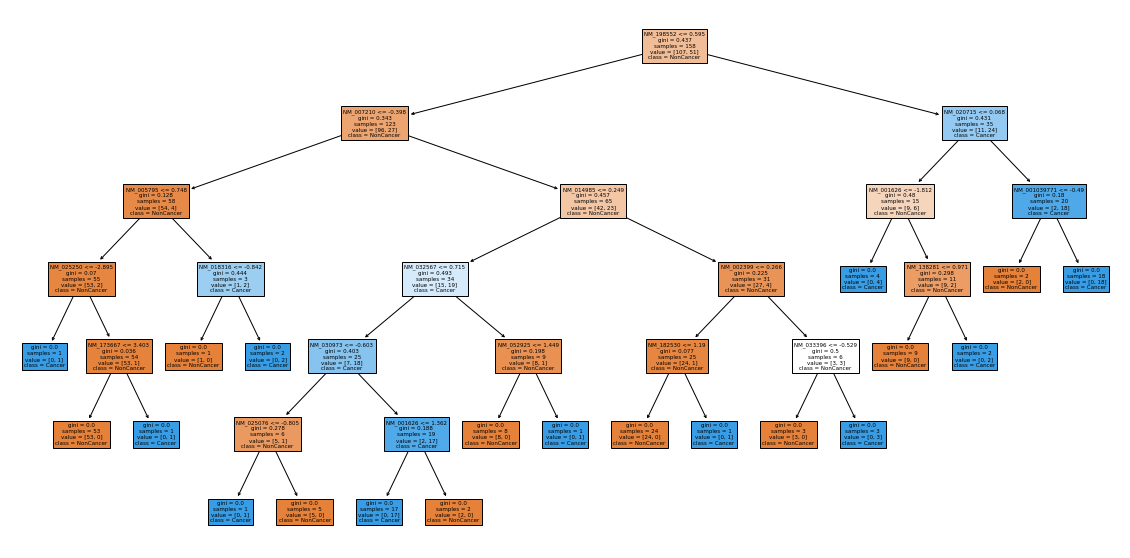

criterion  :  gini
splitter  :  best
max_depth  :  None
min_samples_split  :  2
min_samples_leaf  :  1
min_weight_fraction_leaf  :  0.0
max_features  :  None
max_leaf_nodes  :  None
random_state  :  None
min_impurity_decrease  :  0.0
class_weight  :  None
ccp_alpha  :  0.0
n_features_in_  :  122
n_outputs_  :  1
classes_  :  [0 1]
n_classes_  :  2
max_features_  :  122
tree_  :  <sklearn.tree._tree.Tree object at 0x7f827f504c70>

Accuracy: 0.7391304347826086


In [27]:

# create the decision tree classifier
clf = DecisionTreeClassifier()
# fit the classifier to the training data
clf.fit(X_train_norm, y_train)
# make predictions on the test data
y_pred = clf.predict(X_test_norm)
# evaluate the model's performance
accuracy = clf.score(X_test_norm, y_test)


# Plot the decision tree
plt.figure(figsize=(20,10))
a = plot_tree(clf, filled=True, 
              feature_names=list(X_train.keys()), 
              class_names=["NonCancer" , "Cancer"])
plt.show() 



for key in clf.__dict__.keys():
  print(key, " : " , clf.__dict__[key])
print()
print("Accuracy:", accuracy)
